In [10]:
import bz2
import json
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from itertools import compress

!pip install tld
from tld import get_tld

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read the filtered data and create a data frame. This is the one we use for analyses! 

In [3]:
YEAR = '2020'
PATH_FILTERED_DATA = f'/content/drive/MyDrive/ADAMilestone2/Data/quotes-{YEAR}-UK-filtered.json.bz2'
df = pd.read_json(PATH_FILTERED_DATA, compression='bz2', lines=True)

Read the parquet file and create a data frame

In [4]:
df_parquet = pd.read_parquet('/content/drive/MyDrive/ADAMilestone2/speaker_attributes.parquet')

## Some descriptive statistics at Newspaper level

We can group the quotes based on which newssource they appear in. With this we can now look at some basic differences between newssources. Currently we have the following newssources

- The Sun
- Daily Mail
- Metro
- The Times
- London Evening Standard
- The Mirror
- The Telegraph
- BBC
- The Independent
- The Guardian
- Sky News
- ITV

Start by simply counting the number of avaliable quotations from each news source.

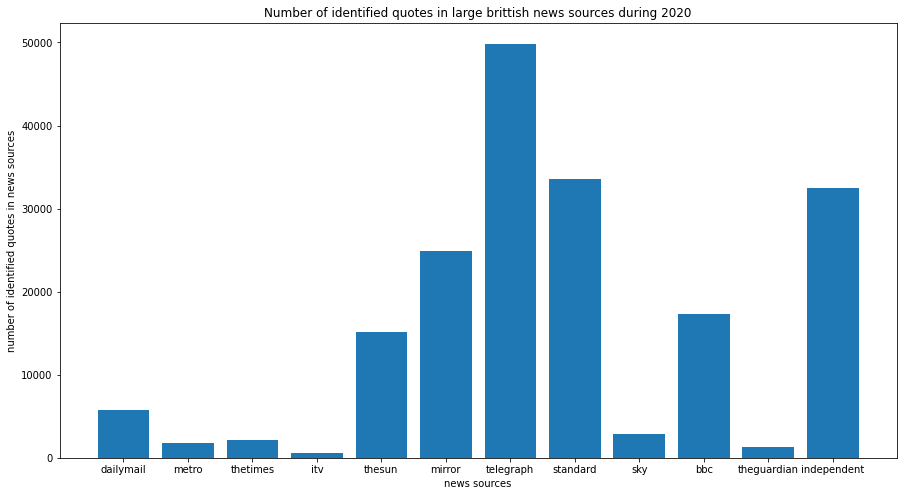

In [6]:
news_names = {source for sources in df.newspapers for source in sources}
quote_count = {source: 0 for source in news_names}
for newspaper in news_names:
  count = df.newspapers.map(lambda news_list: newspaper in news_list).sum()
  #print(f'number of quotes from {newspaper}: {count}')
  quote_count[newspaper] = count

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(*zip(*quote_count.items()))
ax.set_xlabel('news sources')
ax.set_ylabel('number of identified quotes in news sources')
ax.set_title(f'Number of identified quotes in large brittish news sources during {YEAR}');

We now check the number of newspapers each quote has been cited in and group these quotes together.

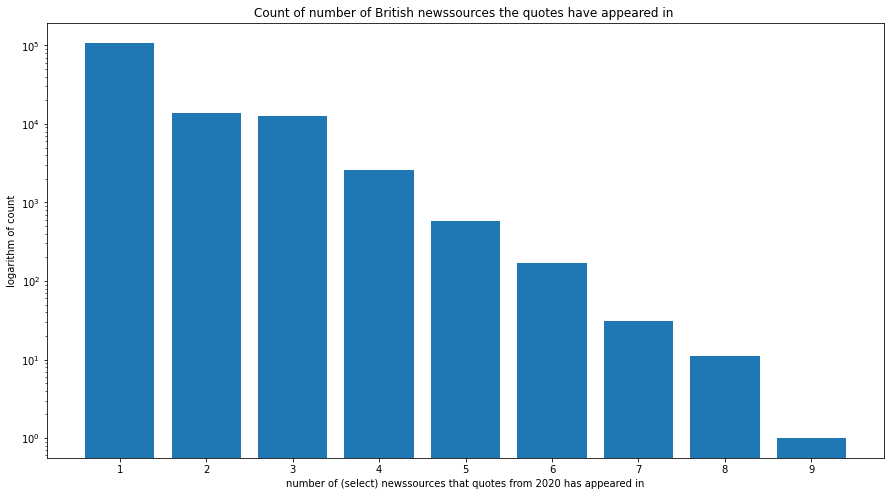

In [5]:
counts = df.newspapers.map(lambda sources: len(sources)).unique()
number_newspapers = {count: df.newspapers.map(lambda sources: len(sources) == count).sum()
                     for count in counts}

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(*zip(*number_newspapers.items()))
ax.set_yscale('log')
ax.set_ylabel('logarithm of count')
ax.set_xlabel(f'number of (select) newssources that quotes from {YEAR} has appeared in')
ax.set_title('Count of number of British newssources the quotes have appeared in ')
ax.set_xticks(np.arange(1, len(counts) + 1));


We now look at newspaper pairs and see if some newspapers use the same quotes more often than others. This is represented by a matrix with counts indicating how many times two newspapers have used the same quotation. 

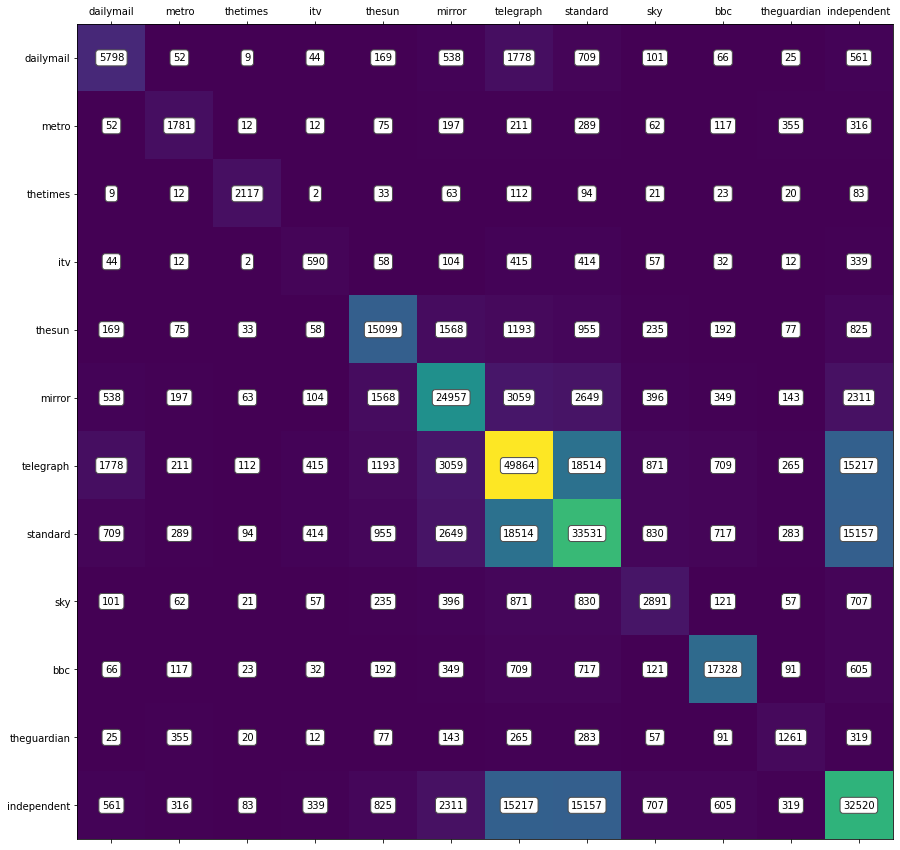

In [8]:
source_list = list(news_names)
source_pairs = [(source_1, source_2) for (i, source_1) in enumerate(source_list, 0) for source_2 in source_list[i:]]
same_quotes = np.zeros([len(source_list)]*2)
corr_quotes = np.zeros([len(source_list)]*2)
for i, source_1 in enumerate(source_list):
    for j, source_2 in enumerate(source_list):
        count = df.newspapers.map(lambda sources: source_1 in sources and source_2 in sources).sum()
        same_quotes[i, j] = count
        corr_quotes[i, j] = count / np.sqrt(quote_count[source_1]*quote_count[source_2])
        #print(f'{source_1}, {source_2}: count: {count} corr_qountes: {corr_quotes[i, j]}')
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(same_quotes)
for (i, j), count in np.ndenumerate(same_quotes):
    ax.text(j, i, '{:n}'.format(count), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
ax.set_xticks(np.arange(0, len(source_list)))
ax.set_yticks(np.arange(0, len(source_list)))
ax.set_xticklabels(source_list)
ax.set_yticklabels(source_list);

We're able to see some interesting things from this matrix. About half of the quotes from the Evening Standard appear in the independent and vice versa. This seems reasonable since they share the same owner and seem to have some overlap in their online content. 

Quotes from the Telegraph make up over half of the Evening Standard's quotes and almost a half of the Independent's quotes. A quick google doesn't show any clear links between the Telegraph and these two newspapers though which could be something interesting to investigate.

One problem with this representation of sameness in quotes is that a newspaper which has a lot of quotes in the data will seem more alike other newspapers. We would therefore like to find a way to better show correletions between the quotes. 

To do this we propose using a modified version of the Pearson correlation coefficient. Let $x_{i, j}$ represent the number of quotes which appear in both newssource $i$ and $j$. For clarification: $x_{i, i}$ will be the number of quotes that appear in newspaper $i$. We then define the matrix $C$ as

\begin{equation}
  C_{i, j} = \frac{x_{i, j}}{\sqrt{x_{i, i} \; x_{j, j}}}.
\end{equation}

We then get something very similar to a correlation matrix which ranges from 0 to 1. By calculating this matrix we can see some more correlations in what quotes newspapers have.

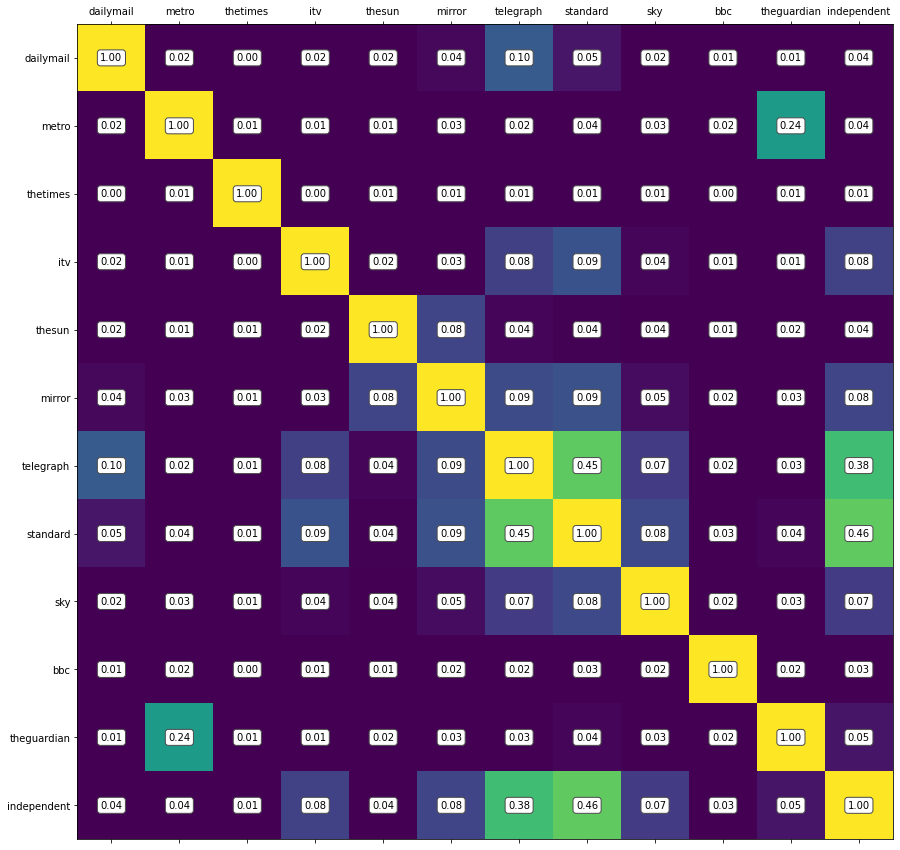

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(corr_quotes, norm=colors.LogNorm(vmin=corr_quotes.min()+0.04, vmax=corr_quotes.max()))
for (i, j), count in np.ndenumerate(corr_quotes):
    ax.text(j, i, f'{count:.2f}', ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

ax.set_xticks(np.arange(0, len(source_list)))
ax.set_yticks(np.arange(0, len(source_list)))
ax.set_xticklabels(source_list)
ax.set_yticklabels(source_list);

Now we can see a correlation which was not visible in the original matrix, namely that Metro and the Guardian share a lot of the same quotes. This could also be interesting to look at.

Now we want to look further into the quotes of interesting speakers. The first function is used to find indicies from the parquet based on a column and qid. The second function is used to find the number of times that these speakers have been quoted in a dataframe.

In [12]:
# Function to retrive indices from parquet depending on column [str] and value [str]. column should contain lists
def retrive_indices_parquet(column, value):
    not_na = df_parquet.loc[df_parquet[column].dropna().index]
    return not_na[not_na[column].map(lambda col_list: value in col_list)].index

# Returns a list containing the frequencies of the speakers in data frame df, with indices "indices" from df_parquet
def vectorize_quotes_by_speaker(df, indices):
    occurences = [0]*len(indices)
    speakers = df_parquet.loc[indices]["label"].tolist()
    df_speakers = df[df['speaker'].isin(speakers)]
    for i, speaker in enumerate(speakers):
        occurences[i] = df_speakers[df_speakers.speaker == speaker]["numOccurrences"].count()
    return occurences

Based on the qids for the Conservative party and the Labour party, two frequencies vector can be obtained using the functions above. 

In [13]:
parties = ['Q9626', 'Q9630'] # Conservative Party, Labour Party
column = 'party'

conservative_indices = retrive_indices_parquet(column, parties[0])
conservative_speakers = df_parquet.loc[conservative_indices]["label"].tolist()
conservative_freq_speakers = vectorize_quotes_by_speaker(df, conservative_indices)

labour_indices = retrive_indices_parquet(column, parties[1])
labour_speakers = df_parquet.loc[labour_indices]["label"].tolist()
labour_freq_speakers = vectorize_quotes_by_speaker(df, labour_indices)

This show that the most quoted speakers were the following, with number of quotes according to

In [14]:
print("The 5 most commonly quoted conservative speakers during ", YEAR)
temp = np.array(conservative_freq_speakers)
temp_indices = (-temp).argsort()[:5]
for speaker,freq in zip(np.array(conservative_speakers)[temp_indices],temp[temp_indices]):
        print('{}: {}'.format(speaker,freq))

print("\nThe 5 most commonly quoted labour speakers during ", YEAR)
temp = np.array(labour_freq_speakers)
temp_indices = (-temp).argsort()[:5]
for speaker,freq in zip(np.array(labour_speakers)[temp_indices],temp[temp_indices]):
        print('{}: {}'.format(speaker,freq))

The 5 most commonly quoted conservative speakers during  2020
Boris Johnson: 1889
Matt Hancock: 1202
Rishi Sunak: 494
Dominic Raab: 491
Grant Shapps: 299

The 5 most commonly quoted labour speakers during  2020
Keir Starmer: 438
Jeremy Corbyn: 350
Sadiq Khan: 334
Lisa Nandy: 293
Rebecca Long-Bailey: 220


The distributions of the occurencies are then plotted in a histogram using log-scale on the y-axis. 

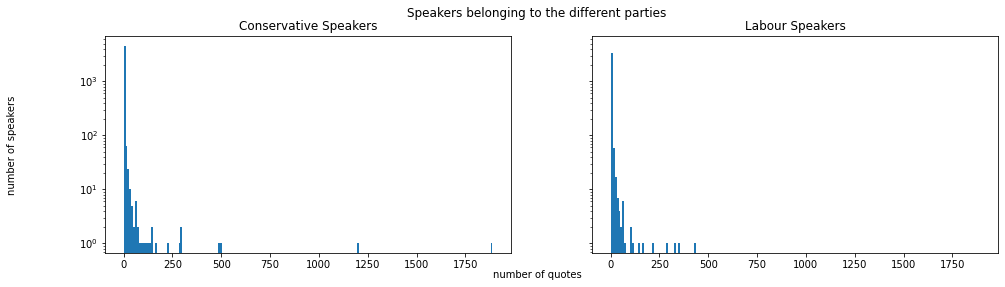

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16,4), sharey=True, sharex=True)
fig.suptitle('Speakers belonging to the different parties')
axs[0].hist(conservative_freq_speakers, bins=int(max(conservative_freq_speakers)/10), log=True)
axs[0].set_title("Conservative Speakers")
axs[1].hist(labour_freq_speakers, bins=int(max(labour_freq_speakers)/10), log=True)
axs[1].set_title("Labour Speakers")
fig.text(0.5, 0.04, 'number of quotes', ha='center')
fig.text(0.04, 0.5, 'number of speakers', va='center', rotation='vertical');

Unsuprisingly, it shows that most conservatives and labours was not quoted at all during this year. This is still useful knowledge when making an analysis through time, but in order to retrive more information all these values can be dropped. This was done and the filtered list was used in a boxplot.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


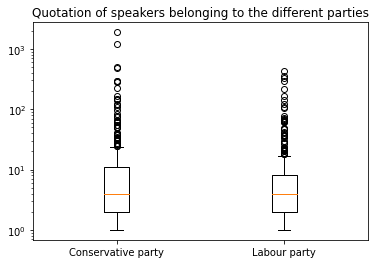

In [16]:
conservative_speakers_nz = list(compress(conservative_speakers, conservative_freq_speakers))
conservative_freq_speakers_nz = list(compress(conservative_freq_speakers, conservative_freq_speakers))
labour_speakers_nz = list(compress(labour_speakers, labour_freq_speakers))
labour_freq_speakers_nz = list(compress(labour_freq_speakers, labour_freq_speakers))

concatenated = [conservative_freq_speakers_nz, labour_freq_speakers_nz]
fig, ax = plt.subplots()
ax.set_title('Quotation of speakers belonging to the different parties')
ax.boxplot(concatenated)
ax.set_xticklabels(['Conservative party', 'Labour party'])
plt.yscale('log')
plt.show();

The non-zero frequencies can also be represented using other statistics. Creating a dataframe and using the describe-function, gives the following information.

In [17]:
pd.DataFrame(conservative_freq_speakers_nz).describe().round() 

,0
count,460.0
mean,22.0
std,113.0
min,1.0
25%,2.0
50%,4.0
75%,11.0
max,1889.0


In [18]:
pd.DataFrame(labour_freq_speakers_nz).describe().round()

,0
count,521.0
mean,11.0
std,36.0
min,1.0
25%,2.0
50%,4.0
75%,8.0
max,438.0


The statistic analysis between the two parties shows some differences. More labour speakers are quoted, while the most frequently qouted people belong to the conservative party. The fact that these distributions differ should not be a problem since it is only the comparation between the newspapers that will be used during the clustering. It is although important to make sure that both parties are weighted equally.

In [19]:
#Seperate quotes on newssection
#Politics [Occupation | Q82955]
column = 'occupation'
value = 'Q82955'
indices = retrive_indices_parquet(column, value)
df_politicians = df_parquet.loc[indices]

#double check if right occupation code was used
df_politicians[df_politicians['label'] == 'Barack Obama']
df_politicians[df_politicians['label'] == 'Hillary Clinton']

#Do same for foreign politics, sports, culture, economics, science?

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
1135081,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[Q30],[Q6581072],1393846565,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,Hillary Clinton,"[Q699872, Q4791768]",item,[Q33203]


# Nytt avsnitt

In [ ]:
!pip install flair
from flair import *

     |████████████████████████████████| 319 kB 27.6 MB/s 
     |████████████████████████████████| 59 kB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 64 kB 3.2 MB/s 
     |████████████████████████████████| 1.2 MB 41.3 MB/s 
     |████████████████████████████████| 19.7 MB 66.8 MB/s 
     |████████████████████████████████| 981 kB 55.7 MB/s 
     |████████████████████████████████| 3.1 MB 53.9 MB/s 
     |████████████████████████████████| 48 kB 3.5 MB/s 
     |████████████████████████████████| 788 kB 53.6 MB/s 
     |████████████████████████████████| 62 kB 861 kB/s 
     |████████████████████████████████| 3.3 MB 56.9 MB/s 
     |████████████████████████████████| 895 kB 48.5 MB/s 
     |████████████████████████████████| 596 kB 38.9 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=e97e9718fdf36bd46ac322542cf458fca778423e0512

Extra: Following functions are going to be used to add sentiment scores in the sentiment analysis.

In [ ]:
#Do sentiment analysis on a single quote
def sentiment(quote):
  flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
  s = flair.data.Sentence(quote)
  flair_sentiment.predict(s)
  total_sentiment = s.labels[0].to_dict()
  return total_sentiment

In [ ]:
# Add a sentiment column to a dataframe in a file
def add_sentiment_scores(path_to_file, path_to_out):
  with bz2.open(path_to_file, 'rb') as s_file:
      with bz2.open(path_to_out, 'wb') as d_file:
          for index, instance in enumerate(s_file):
              instance = json.loads(instance) # loading a sample
              quote = instance['quotation']
              print(sentiment(quote)['value'])
              if 'POSITIVE' in sentiment(quote)['value']:
                instance['quote_sentiment'] = 1
              else:
                instance['quote_sentiment'] = 0
              d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
              if index == 10:
                break